In [44]:
from ripser import ripser
import matplotlib.pyplot as plt
import math
from persim import plot_diagrams
import tadasets
from persim import plot_diagrams
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances
from scipy import sparse
import time

In [45]:
def plot3d(data, fig=None, ax=None, **params):
    fig = fig if fig else plt.figure()

    ax = ax if ax else fig.add_subplot(111, projection="3d")
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], **params)
    return ax

__all__ = ["plot3d"]

In [46]:
def getWiseGreedyPerm(D):
    """
    A Naive O(N^2) algorithm to do furthest points sampling

    Parameters
    ----------
    D : ndarray (N, N)
        An NxN distance matrix for points

    Return
    ------
    lamdas: list
        Insertion radii of all points
    """

    N = D.shape[0]
    perm = np.zeros(N, dtype=np.int64)
    lambdas = np.zeros(N)
    m=0
    ds = D[0, :]
    for i in range(1,N):
        if np.amax(D[i,:])<np.amax(ds): 
            ds=D[i,:]
            m=i
    perm[0]=m
    for i in range(1, N):
        idx = np.argmax(ds)
        perm[i] = idx
        lambdas[i] = ds[idx]
        ds = np.minimum(ds, D[idx, :])
    return lambdas[perm]

In [47]:
def getGreedyPerm(D):
    """
    A Naive O(N^2) algorithm to do furthest points sampling

    Parameters
    ----------
    D : ndarray (N, N)
        An NxN distance matrix for points

    Return
    ------
    lamdas: list
        Insertion radii of all points
    """

    N = D.shape[0]
    #By default, takes the first point in the permutation to be the
    #first point in the point cloud, but could be random
    perm = np.zeros(N, dtype=np.int64)
    lambdas = np.zeros(N)
    ds = D[0, :]
    for i in range(1, N):
        idx = np.argmax(ds)
        perm[i] = idx
        lambdas[i] = ds[idx]
        ds = np.minimum(ds, D[idx, :])
    return lambdas[perm]

In [48]:
def getApproxSparseDM(lambdas, eps, D):
    """
    Purpose: To return the sparse edge list with the warped distances, sorted by weight

    Parameters
    ----------
    lambdas: list
        insertion radii for points
    eps: float
        epsilon approximation constant
    D: ndarray
        NxN distance matrix, okay to modify because last time it's used

    Return
    ------
    DSparse: scipy.sparse
        A sparse NxN matrix with the reweighted edges
    """
    N = D.shape[0]
    E0 = (1+eps)/eps
    E1 = (1+eps)**2/eps

    # Create initial sparse list candidates (Lemma 6)
    # Search neighborhoods
    nBounds = ((eps**2+3*eps+2)/eps)*lambdas

    # Set all distances outside of search neighborhood to infinity
    D[D > nBounds[:, None]] = np.inf
    [I, J] = np.meshgrid(np.arange(N), np.arange(N))
    idx = I < J
    I = I[(D < np.inf)*(idx == 1)]
    J = J[(D < np.inf)*(idx == 1)]
    D = D[(D < np.inf)*(idx == 1)]

    #Prune sparse list and update warped edge lengths (Algorithm 3 pg. 14)
    minlam = np.minimum(lambdas[I], lambdas[J])
    maxlam = np.maximum(lambdas[I], lambdas[J])

    # Rule out edges between vertices whose balls stop growing before they touch
    # or where one of them would have been deleted.  M stores which of these
    # happens first
    M = np.minimum((E0 + E1)*minlam, E0*(minlam + maxlam))

    t = np.arange(len(I))
    t = t[D <= M]
    (I, J, D) = (I[t], J[t], D[t])
    minlam = minlam[t]
    maxlam = maxlam[t]

    # Now figure out the metric of the edges that are actually added
    t = np.ones(len(I))

    # If cones haven't turned into cylinders, metric is unchanged
    t[D <= 2*minlam*E0] = 0

    # Otherwise, if they meet before the M condition above, the metric is warped
    D[t == 1] = 2.0*(D[t == 1] - minlam[t == 1]*E0) # Multiply by 2 convention
    return sparse.coo_matrix((D, (I, J)), shape=(N, N)).tocsr()

Elapsed Time: 12.2 seconds, 1999000 Edges added


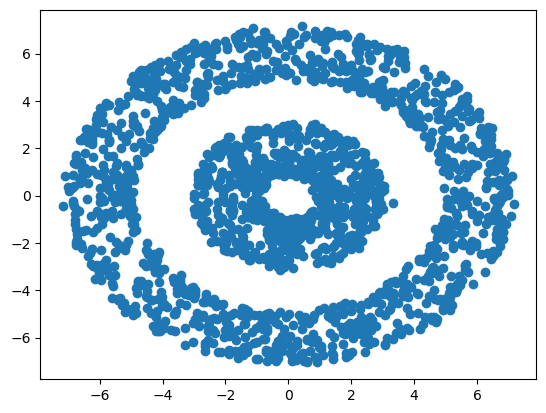

In [49]:
X=np.concatenate([
    tadasets.torus(n=1250, c=6 ,a=1, noise=0.1),
    tadasets.torus(n=750, c=2, a=1, noise=0.1)])
plt.scatter(X[:, 0], X[:, 1])
tic = time.time()
resultfull = ripser(X)
toc = time.time()
timefull = toc-tic
print("Elapsed Time: %.3g seconds, %i Edges added"%(timefull, resultfull['num_edges']))

In [57]:
eps = 0.1

# Compute the sparse filtration
tic = time.time()

# First compute all pairwise distances and do furthest point sampling
D = pairwise_distances(X, metric='euclidean')
#lambdas = getGreedyPerm(D)
lambdas = getWiseGreedyPerm(D)
# Now compute the sparse distance matrix
DSparse = getApproxSparseDM(lambdas, eps, D)

# Finally, compute the filtration
resultsparse = ripser(DSparse, thresh=math.inf, distance_matrix=True)
toc = time.time()
timesparse = toc-tic
percent_added = 100.0*float(resultsparse['num_edges'])/resultfull['num_edges']
print("Elapsed Time: %.3g seconds, %i Edges added"%(timesparse, resultsparse['num_edges']))

Elapsed Time: 4.38 seconds, 899399 Edges added


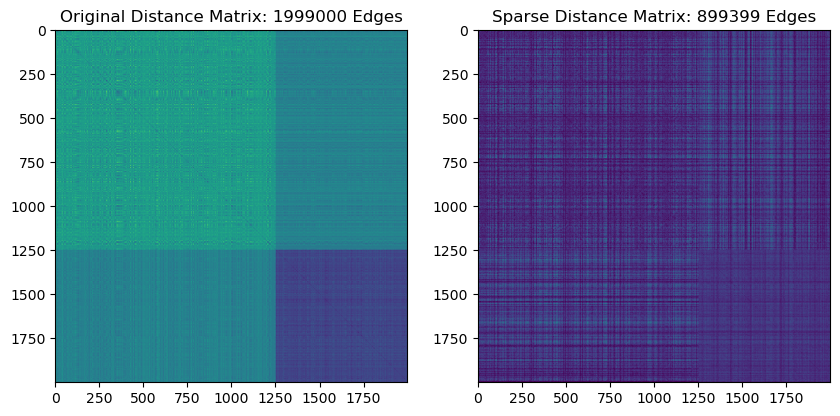

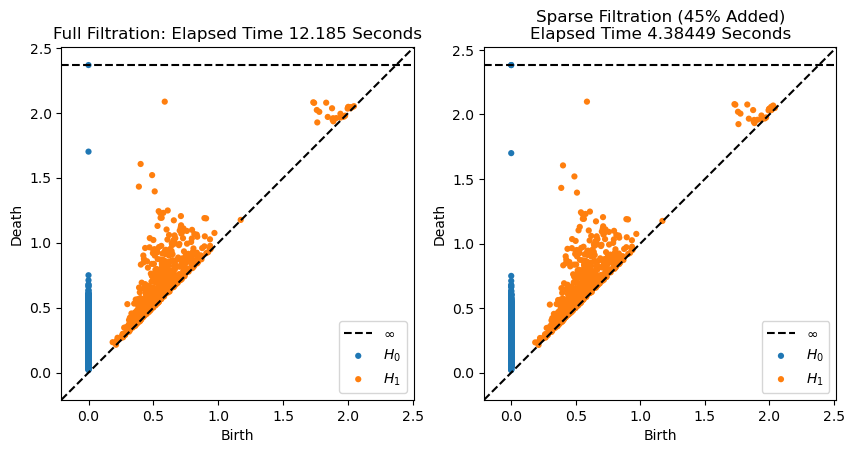

In [58]:
# Plot the sparse distance matrix and edges that were added
plt.figure(figsize=(10, 5))
plt.subplot(121)
D = pairwise_distances(X, metric='euclidean')
plt.imshow(D)
plt.title("Original Distance Matrix: %i Edges"%resultfull['num_edges'])
plt.subplot(122)
DSparse = DSparse.toarray()
DSparse = DSparse + DSparse.T
plt.imshow(DSparse)
plt.title("Sparse Distance Matrix: %i Edges"%resultsparse['num_edges'])

# And plot the persistence diagrams on top of each other
plt.figure(figsize=(10, 5))
plt.subplot(121)
plot_diagrams(resultfull['dgms'], show=False)
plt.title("Full Filtration: Elapsed Time %g Seconds"%timefull)
plt.subplot(122)
plt.title("Sparse Filtration (%.3g%% Added)\nElapsed Time %g Seconds"%(percent_added, timesparse))
plot_diagrams(resultsparse['dgms'], show=False)#, xy_range=[-0.4,6.25,-0.25,6.25])

In [52]:
eps = 0.4

# Compute the sparse filtration
tic = time.time()

# First compute all pairwise distances and do furthest point sampling
D = pairwise_distances(X, metric='euclidean')
lambdas = getGreedyPerm(D)
#lambdas = getWiseGreedyPerm(D)
# Now compute the sparse distance matrix
DSparse = getApproxSparseDM(lambdas, eps, D)

# Finally, compute the filtration
resultsparse = ripser(DSparse, thresh=math.inf, distance_matrix=True)
toc = time.time()
timesparse = toc-tic
percent_added = 100.0*float(resultsparse['num_edges'])/resultfull['num_edges']
print("Elapsed Time: %.3g seconds, %i Edges added"%(timesparse, resultsparse['num_edges']))

Elapsed Time: 0.799 seconds, 176546 Edges added


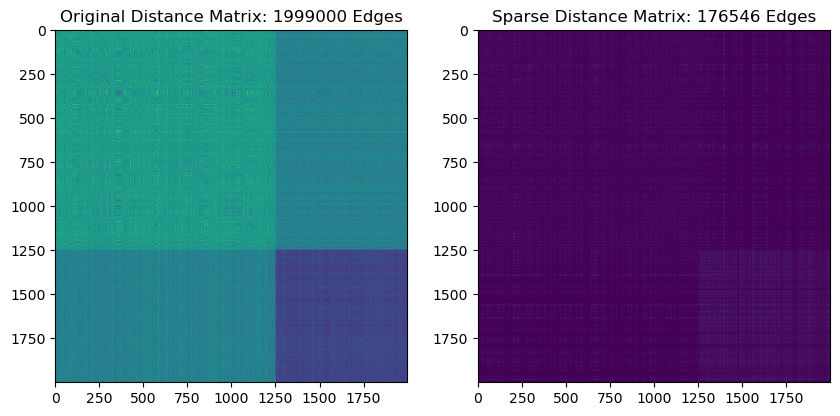

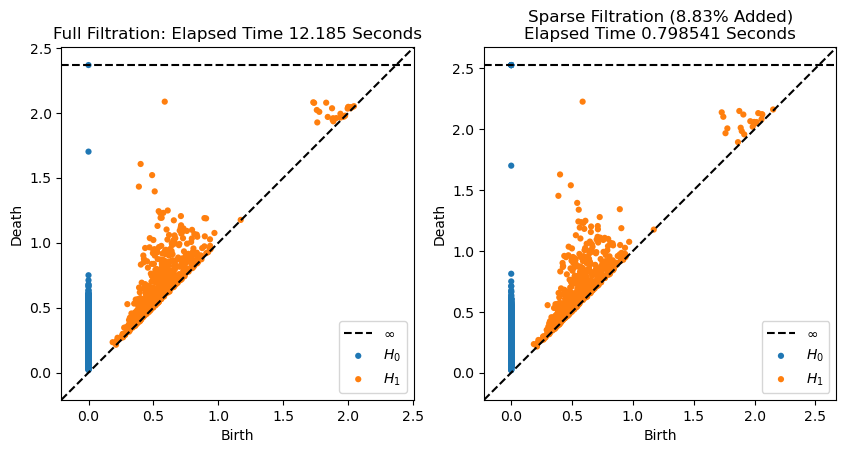

In [53]:
#Plot the sparse distance matrix and edges that were added
plt.figure(figsize=(10, 5))
plt.subplot(121)
D = pairwise_distances(X, metric='euclidean')
plt.imshow(D)
plt.title("Original Distance Matrix: %i Edges"%resultfull['num_edges'])
plt.subplot(122)
DSparse = DSparse.toarray()
DSparse = DSparse + DSparse.T
plt.imshow(DSparse)
plt.title("Sparse Distance Matrix: %i Edges"%resultsparse['num_edges'])

#And plot the persistence diagrams on top of each other
plt.figure(figsize=(10, 5))
plt.subplot(121)
plot_diagrams(resultfull['dgms'], show=False)
plt.title("Full Filtration: Elapsed Time %g Seconds"%timefull)
plt.subplot(122)
plt.title("Sparse Filtration (%.3g%% Added)\nElapsed Time %g Seconds"%(percent_added, timesparse))
plot_diagrams(resultsparse['dgms'], show=False)#, xy_range=[-0.125,1.6,-0.125,1.6])

In [54]:
eps = 0.9

# Compute the sparse filtration
tic = time.time()

# First compute all pairwise distances and do furthest point sampling
D = pairwise_distances(X, metric='euclidean')
#lambdas = getGreedyPerm(D)
lambdas = getWiseGreedyPerm(D)
# Now compute the sparse distance matrix
DSparse = getApproxSparseDM(lambdas, eps, D)

# Finally, compute the filtration
resultsparse = ripser(DSparse, thresh=math.inf, distance_matrix=True)
toc = time.time()
timesparse = toc-tic
percent_added = 100.0*float(resultsparse['num_edges'])/resultfull['num_edges']
print("Elapsed Time: %.3g seconds, %i Edges added"%(timesparse, resultsparse['num_edges']))

Elapsed Time: 0.474 seconds, 81183 Edges added


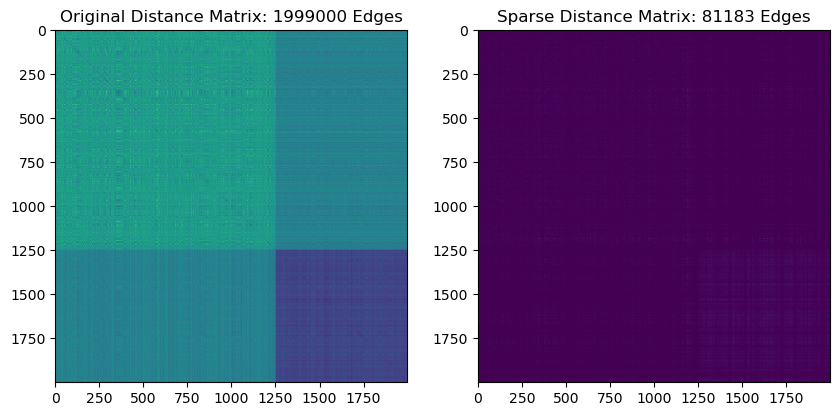

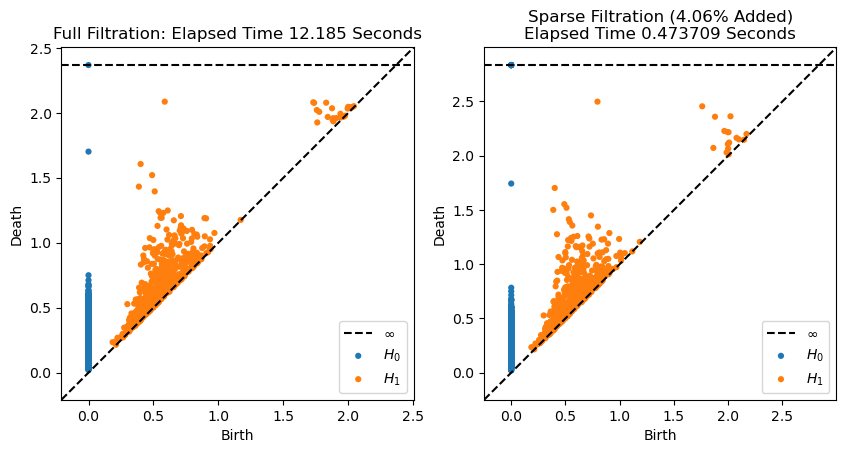

In [55]:
#Plot the sparse distance matrix and edges that were added
plt.figure(figsize=(10, 5))
plt.subplot(121)
D = pairwise_distances(X, metric='euclidean')
plt.imshow(D)
plt.title("Original Distance Matrix: %i Edges"%resultfull['num_edges'])
plt.subplot(122)
DSparse = DSparse.toarray()
DSparse = DSparse + DSparse.T
plt.imshow(DSparse)
plt.title("Sparse Distance Matrix: %i Edges"%resultsparse['num_edges'])

#And plot the persistence diagrams on top of each other
plt.figure(figsize=(10, 5))
plt.subplot(121)
plot_diagrams(resultfull['dgms'], show=False)
plt.title("Full Filtration: Elapsed Time %g Seconds"%timefull)
plt.subplot(122)
plt.title("Sparse Filtration (%.3g%% Added)\nElapsed Time %g Seconds"%(percent_added, timesparse))
plot_diagrams(resultsparse['dgms'], show=False)#, xy_range=[-0.125,2.5,-0.125,2.5])

In [56]:
X

array([[ 0.79575989,  5.0562786 , -0.26993875],
       [-5.64966182,  2.88657085, -0.95122651],
       [-6.8593643 , -0.31833348, -0.78231195],
       ...,
       [-0.01958878, -2.78742821, -0.59963093],
       [-0.90444405,  0.75905147,  0.53891372],
       [-2.45873462,  1.27150351,  0.56693599]])